# IQA Metrics Comparative Analysis

**Comprehensive evaluation of Image Quality Assessment metrics across multiple datasets**

This notebook provides a systematic comparison of various IQA metrics including:
- Traditional metrics (PSNR, SSIM, MSE)
- Perceptual metrics (LPIPS, FSIM, VSI)
- No-reference metrics (BRISQUE, NIQE)
- Modern deep learning-based metrics

**Datasets analyzed:**
- BAPPS (Berkeley-Adobe Perceptual Patch Similarity)
- LIVE-MD (Mobile Device Image Database) 
- Custom datasets

**Analysis includes:**
- Metric correlation analysis
- Performance comparison
- Statistical significance testing
- Visualization of results

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
from PIL import Image
import time
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# Custom IQA metrics
from iqa_metrics import IQAMetrics

# Configure display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set up notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

print("📊 IQA Comparative Analysis Environment Ready")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

/Users/saikirannunemunthala/Files/Lectures/Thesis/MetricAnalysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📊 IQA Comparative Analysis Environment Ready
NumPy: 2.2.6
Pandas: 2.2.3
Matplotlib: 3.10.3
Seaborn: 0.13.2


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Initialize IQA Metrics Evaluator
print("🔧 Initializing IQA Metrics Suite...")

# Initialize our comprehensive metrics evaluator
iqa = IQAMetrics(device='auto')

# Display available metrics
available_metrics = iqa.get_available_metrics()
full_ref_metrics = iqa.get_available_metrics('full_reference')
no_ref_metrics = iqa.get_available_metrics('no_reference')

print(f"\n✅ Metrics Initialization Complete")
print(f"📊 Total available metrics: {len(available_metrics)}")
print(f"🔗 Full-reference metrics: {len(full_ref_metrics)}")
print(f"🔍 No-reference metrics: {len(no_ref_metrics)}")

print("\n📋 Available Metrics by Category:")
for category in ['structural', 'signal', 'perceptual', 'feature', 'blind']:
    category_metrics = iqa.get_metrics_by_category(category)
    if category_metrics:
        print(f"  {category.title()}: {category_metrics}")

🔧 Initializing IQA Metrics Suite...
🔧 IQA Metrics Evaluator initialized
   Device: cpu
   Target size: (256, 256)

📊 Initializing IQA metrics...
   ✅ SSIM: Structural Similarity Index (pyiqa)
   ✅ MS-SSIM: Multi-Scale Structural Similarity (pyiqa)
   ✅ UIQI (Custom): Universal Image Quality Index (Custom Implementation)
   ✅ PSNR: Peak Signal-to-Noise Ratio (pyiqa)
   ✅ MSE (Custom): Mean Squared Error (Custom Implementation)
   ✅ MAE (Custom): Mean Absolute Error (Custom Implementation)
   ✅ RMSE (Custom): Root Mean Squared Error (Custom Implementation)
Loading pretrained model LPIPS from /Users/saikirannunemunthala/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
   ✅ LPIPS: Learned Perceptual Image Patch Similarity
   ✅ FSIM: Feature Similarity Index (pyiqa)
   ✅ VSI: Visual Saliency Index (pyiqa)
   ✅ GMSD: Gradient Magnitude Similarity Deviation (pyiqa)
   ✅ BRISQUE: Blind/Referenceless Image Spatial Quality Evaluator (pyiqa)
   ✅ NIQE: Natural Image Quality Evaluator (pyiqa)
 

## Load Datasets

This section handles loading and preprocessing of various IQA datasets:
- **BAPPS**: Berkeley-Adobe Perceptual Patch Similarity dataset
- **LIVE-MD**: Mobile Device Image Database
- **Custom datasets**: Additional evaluation datasets

In [3]:
# Load BAPPS Dataset
def load_bapps_dataset(csv_path: str = "BAPPS/BAPPS.txt", num_samples: int = None) -> pd.DataFrame:
    """
    Load BAPPS dataset from CSV file.
    
    Args:
        csv_path: Path to BAPPS CSV file
        num_samples: Number of samples to load (None for all)
    
    Returns:
        DataFrame with BAPPS data
    """
    print(f"📊 Loading BAPPS dataset from: {csv_path}")
    
    # Try different possible paths
    possible_paths = [
        csv_path,
        "BAPPS/dataset/BAPPS.txt",
        "BAPPS/BAPPS.txt"
    ]
    
    df = None
    for path in possible_paths:
        if os.path.exists(path):
            try:
                df = pd.read_csv(path)
                print(f"✅ Successfully loaded from: {path}")
                break
            except Exception as e:
                print(f"⚠️ Error loading from {path}: {e}")
                continue
    
    if df is None:
        print(f"❌ Could not load BAPPS dataset from any path")
        return pd.DataFrame()
    
    print(f"📋 Found {len(df)} total samples in BAPPS dataset")
    
    if num_samples:
        df = df.head(num_samples)
        print(f"🔍 Using {len(df)} samples for analysis")
    
    # Display sample
    print("\n📄 Sample data:")
    display(df.head(3))
    
    return df

# Load BAPPS dataset
bapps_df = load_bapps_dataset(num_samples=200)  # Start with 200 samples for faster analysis

📊 Loading BAPPS dataset from: BAPPS/BAPPS.txt
✅ Successfully loaded from: BAPPS/BAPPS.txt
📋 Found 187744 total samples in BAPPS dataset
🔍 Using 200 samples for analysis

📄 Sample data:


,ref_img_path,dis_img_path0,dis_img_path1,dis_type,judge/same,split
0,BAPPS/dataset/2afc/train/cnn/ref/000000.png,BAPPS/dataset/2afc/train/cnn/p0/000000.png,BAPPS/dataset/2afc/train/cnn/p1/000000.png,BAPP_distortions,0.0,NaN
1,BAPPS/dataset/2afc/train/cnn/ref/000001.png,BAPPS/dataset/2afc/train/cnn/p0/000001.png,BAPPS/dataset/2afc/train/cnn/p1/000001.png,BAPP_distortions,0.0,NaN
2,BAPPS/dataset/2afc/train/cnn/ref/000002.png,BAPPS/dataset/2afc/train/cnn/p0/000002.png,BAPPS/dataset/2afc/train/cnn/p1/000002.png,BAPP_distortions,0.0,NaN


In [4]:
# Load LIVE-MD Dataset
def load_live_md_dataset(csv_path: str = "LIVE_MD/LIVE_MD.txt" ) -> pd.DataFrame:
    """
    Load LIVE-MD dataset from CSV file.
    
    Args:
        csv_path: Path to LIVE-MD CSV file
        num_samples: Number of samples to load (None for all)
    
    Returns:
        DataFrame with LIVE-MD data
    """
    print(f"📊 Loading LIVE-MD dataset from: {csv_path}")
    
    if not os.path.exists(csv_path):
        print(f"⚠️ LIVE-MD dataset not found at {csv_path}")
        print("Creating placeholder for LIVE-MD dataset structure...")
        
        # Create a placeholder structure for demonstration
        placeholder_data = {
            'ref_img_path': [f'LIVE_MD/To_Release/Ref_Images/img_{i:03d}.png' for i in range(1, 11)],
            'dis_img_path': [f'LIVE_MD/To_Release/Part_1/img_{i:03d}_dist.png' for i in range(1, 11)],
            'mos': np.random.uniform(1, 5, 10),  # Mean Opinion Score
            'distortion_type': ['blur', 'noise', 'compression', 'blur', 'noise'] * 2
        }
        
        df = pd.DataFrame(placeholder_data)
        print(f"📋 Created placeholder with {len(df)} samples")
        return df
    
    try:
        df = pd.read_csv(csv_path)
        print(f"✅ Successfully loaded LIVE-MD dataset")
        print(f"📋 Found {len(df)} total samples")
         
        # Display sample
        print("\n📄 Sample data:")
        display(df.head(3))
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading LIVE-MD dataset: {e}")
        return pd.DataFrame()

# Load LIVE-MD dataset
live_md_df = load_live_md_dataset()

📊 Loading LIVE-MD dataset from: LIVE_MD/LIVE_MD.txt
✅ Successfully loaded LIVE-MD dataset
📋 Found 450 total samples

📄 Sample data:


,dis_img_path,dis_type,ref_img_path,score
0,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,Multiply Dist.,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,21.5789
1,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,Multiply Dist.,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,35.7895
2,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,Multiply Dist.,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,32.6316


## Define Helper Functions

Utility functions for image preprocessing, metric computation, and result aggregation.

In [5]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import time
from typing import Dict, List, Tuple, Optional # MODIFIED: Added this line

# Assuming iqa_metrics.py is in the same directory or accessible in PYTHONPATH
# and contains the IQAMetrics class.
# from iqa_metrics import IQAMetrics # This line would be used if iqa_instance is not passed

# Helper Functions for Image Processing and Metric Evaluation


def aggregate_results(results_list: List[Dict], 
                     group_by: str = None) -> pd.DataFrame:
    """
    Aggregate metric evaluation results into a DataFrame.
    
    Args:
        results_list: List of result dictionaries
        group_by: Column to group results by
    
    Returns:
        DataFrame with aggregated results
    """
    if not results_list:
        return pd.DataFrame()
    
    df = pd.DataFrame(results_list)
    
    if group_by and group_by in df.columns:
        agg_funcs = {}
        for col in df.columns:
            if col != group_by and df[col].dtype in ['float64', 'int64', 'float', 'int']: # Added float and int
                # Check if it's a time column for specific aggregation, otherwise general stats
                if col.endswith('_time'): # Assuming time columns are named like 'metric_time'
                    agg_funcs[col] = ['mean', 'sum'] # Mean and total time might be useful
                else: # For score columns
                    agg_funcs[col] = ['mean', 'std', 'median', 'min', 'max']
        
        if agg_funcs: # Check if there's anything to aggregate
            try:
                summary = df.groupby(group_by).agg(agg_funcs)
                # Flatten MultiIndex columns if created by agg
                summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
                return summary.reset_index() # Return with group_by as a column
            except Exception as e:
                print(f"Error during aggregation: {e}")
                return df # Return original df on error
        else:
            return df # Return original if no suitable columns for aggregation
    
    return df

print("✅ Helper functions defined successfully (with timing capabilities)")

✅ Helper functions defined successfully (with timing capabilities)


## Evaluate Metrics on Datasets

Systematic evaluation of IQA metrics across different datasets with progress tracking and error handling.

In [6]:
# Evaluate Metrics on BAPPS Dataset

def evaluate_bapps_dataset(df: pd.DataFrame, 
                          metrics_subset: List[str] = None,
                          max_samples: int = None) -> pd.DataFrame:
    """
    Evaluate IQA metrics on BAPPS dataset, including computation time.
    
    Args:
        df: BAPPS DataFrame
        metrics_subset: Subset of metrics to evaluate
        max_samples: Maximum number of samples to process
    
    Returns:
        DataFrame with evaluation results (scores and times)
    """
    print(f"🔬 Starting BAPPS Dataset Evaluation")
    print(f"📊 Dataset size: {len(df)} samples")
    
    if df.empty:
        print("❌ No BAPPS data available")
        return pd.DataFrame()
    
    if metrics_subset is None:
        # Default to a common set of full-reference metrics for BAPPS
        metrics_subset = ['ssim', 'psnr', 'lpips_alex', 'fsim', 'ms_ssim'] 
    
    print(f"🎯 Evaluating metrics: {metrics_subset}")
    
    if max_samples:
        df = df.head(max_samples)
        print(f"🔍 Processing {len(df)} samples")
    
    results_list = []
    successful_evaluations = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating BAPPS"):
        try:
            ref_path = row['ref_img_path']
            p0_path = row['dis_img_path0']
            p1_path = row['dis_img_path1']
            human_judgment = row['judge/same'] # 0 for p0, 1 for p1, 0.5 for same
            
            # Evaluate both pairs (p0 vs ref, p1 vs ref)
            # evaluate_image_pair returns Dict[str, {'score': float, 'time': float}]
            metrics_p0_data = iqa.evaluate_pair(ref_path, p0_path, metrics_subset)
            metrics_p1_data = iqa.evaluate_pair(ref_path, p1_path, metrics_subset)
            
            if metrics_p0_data and metrics_p1_data:
                current_result = {
                    'sample_id': idx,
                    'human_judgment': human_judgment, # Closer to 0 means p0 is preferred, closer to 1 means p1 is preferred
                    'ref_path': ref_path,
                    'p0_path': p0_path,
                    'p1_path': p1_path
                }
                
                valid_metric_scores_for_row = False
                for metric in metrics_subset:
                    data_p0 = metrics_p0_data.get(metric)
                    data_p1 = metrics_p1_data.get(metric)

                    if data_p0 and data_p1 and 'score' in data_p0 and 'score' in data_p1:
                        score_p0 = data_p0['score']
                        time_p0 = data_p0.get('time', np.nan) # Default to NaN if time is missing
                        score_p1 = data_p1['score']
                        time_p1 = data_p1.get('time', np.nan)

                        current_result[f'{metric}_p0_score'] = score_p0
                        current_result[f'{metric}_p0_time'] = time_p0
                        current_result[f'{metric}_p1_score'] = score_p1
                        current_result[f'{metric}_p1_time'] = time_p1
                        
                        # Determine preference based on metric characteristics
                        # metric_info = iqa.get_metric_info().get(metric, {})
                        # higher_better = metric_info.get('higher_better', True)
                        
                        # # Metric preference: True if metric prefers p0 over p1
                        # if higher_better:
                        #     metric_prefers_p0 = score_p0 > score_p1
                        # else:
                        #     metric_prefers_p0 = score_p0 < score_p1
                        metric_prefers_p0 = score_p0 > score_p1

                        current_result[f'{metric}_prefers_p0'] = metric_prefers_p0
                        valid_metric_scores_for_row = True
                    else: # Handle cases where a metric might fail for a pair
                        current_result[f'{metric}_p0_score'] = np.nan
                        current_result[f'{metric}_p0_time'] = np.nan
                        current_result[f'{metric}_p1_score'] = np.nan
                        current_result[f'{metric}_p1_time'] = np.nan
                        current_result[f'{metric}_prefers_p0'] = np.nan


                if valid_metric_scores_for_row:
                    results_list.append(current_result)
                    successful_evaluations += 1
                
        except Exception as e:
            print(f"⚠️ Error processing BAPPS sample {idx} ({ref_path}, {p0_path}, {p1_path}): {e}")
            continue # Skip to the next sample
    
    results_df = pd.DataFrame(results_list)
    
    print(f"\n✅ BAPPS Evaluation Complete")
    if not df.empty:
        print(f"📊 Successful evaluations: {successful_evaluations}/{len(df)}")
        if len(df) > 0:
             print(f"📈 Success rate: {successful_evaluations/len(df)*100:.1f}%")
    else:
        print("📊 No samples processed.")

    return results_df

# Run BAPPS evaluation
if not bapps_df.empty:
    print("\n" + "="*60)
    print("🎯 BAPPS DATASET EVALUATION (with Timing)")
    print("="*60)
    
    # Example: evaluate a subset of metrics
    bapps_metrics_to_run = iqa.metrics.keys()  # Use all available metrics for BAPPS
    bapps_results = evaluate_bapps_dataset(bapps_df, metrics_subset=bapps_metrics_to_run, max_samples=100) # Using a subset for speed
    
    if not bapps_results.empty:
        print(f"\n📋 BAPPS Results summary (incl. time):")
        print(f"Columns: {list(bapps_results.columns)}")
        print(f"Shape: {bapps_results.shape}")
        display(bapps_results.head())
else:
    print("⚠️ Skipping BAPPS evaluation - no data available")
    bapps_results = pd.DataFrame()


🎯 BAPPS DATASET EVALUATION (with Timing)
🔬 Starting BAPPS Dataset Evaluation
📊 Dataset size: 200 samples
🎯 Evaluating metrics: dict_keys(['ssim', 'ms_ssim', 'uiqi', 'psnr', 'mse', 'mae', 'rmse', 'lpips', 'fsim', 'vsi', 'gmsd', 'brisque', 'niqe', 'clipiqa', 'blinds2', 'pique', 'lpips_alex', 'lpips_vgg', 'lpips_squeeze'])
🔍 Processing 100 samples


Evaluating BAPPS: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


✅ BAPPS Evaluation Complete
📊 Successful evaluations: 100/100
📈 Success rate: 100.0%

📋 BAPPS Results summary (incl. time):
Columns: ['sample_id', 'human_judgment', 'ref_path', 'p0_path', 'p1_path', 'ssim_p0_score', 'ssim_p0_time', 'ssim_p1_score', 'ssim_p1_time', 'ssim_prefers_p0', 'ms_ssim_p0_score', 'ms_ssim_p0_time', 'ms_ssim_p1_score', 'ms_ssim_p1_time', 'ms_ssim_prefers_p0', 'uiqi_p0_score', 'uiqi_p0_time', 'uiqi_p1_score', 'uiqi_p1_time', 'uiqi_prefers_p0', 'psnr_p0_score', 'psnr_p0_time', 'psnr_p1_score', 'psnr_p1_time', 'psnr_prefers_p0', 'mse_p0_score', 'mse_p0_time', 'mse_p1_score', 'mse_p1_time', 'mse_prefers_p0', 'mae_p0_score', 'mae_p0_time', 'mae_p1_score', 'mae_p1_time', 'mae_prefers_p0', 'rmse_p0_score', 'rmse_p0_time', 'rmse_p1_score', 'rmse_p1_time', 'rmse_prefers_p0', 'lpips_p0_score', 'lpips_p0_time', 'lpips_p1_score', 'lpips_p1_time', 'lpips_prefers_p0', 'fsim_p0_score', 'fsim_p0_time', 'fsim_p1_score', 'fsim_p1_time', 'fsim_prefers_p0', 'vsi_p0_score', 'vsi_p0_t

,sample_id,human_judgment,ref_path,p0_path,p1_path,ssim_p0_score,ssim_p0_time,ssim_p1_score,ssim_p1_time,ssim_prefers_p0,...,lpips_vgg_p0_score,lpips_vgg_p0_time,lpips_vgg_p1_score,lpips_vgg_p1_time,lpips_vgg_prefers_p0,lpips_squeeze_p0_score,lpips_squeeze_p0_time,lpips_squeeze_p1_score,lpips_squeeze_p1_time,lpips_squeeze_prefers_p0
0,0,0.0,BAPPS/dataset/2afc/train/cnn/ref/000000.png,BAPPS/dataset/2afc/train/cnn/p0/000000.png,BAPPS/dataset/2afc/train/cnn/p1/000000.png,0.720137,0.046119,0.587537,0.032128,True,...,0.528472,0.312571,0.625071,0.312876,False,0.300675,0.024951,0.595492,0.025490,False
1,1,0.0,BAPPS/dataset/2afc/train/cnn/ref/000001.png,BAPPS/dataset/2afc/train/cnn/p0/000001.png,BAPPS/dataset/2afc/train/cnn/p1/000001.png,0.880114,0.033989,0.918714,0.032076,False,...,0.475765,0.325319,0.430234,0.530206,True,0.354997,0.026145,0.326799,0.025693,True
2,2,0.0,BAPPS/dataset/2afc/train/cnn/ref/000002.png,BAPPS/dataset/2afc/train/cnn/p0/000002.png,BAPPS/dataset/2afc/train/cnn/p1/000002.png,0.858076,0.034001,0.652461,0.032331,True,...,0.213196,0.346768,0.406427,0.347545,False,0.130609,0.025245,0.411897,0.025427,False
3,3,0.5,BAPPS/dataset/2afc/train/cnn/ref/000003.png,BAPPS/dataset/2afc/train/cnn/p0/000003.png,BAPPS/dataset/2afc/train/cnn/p1/000003.png,0.796550,0.035461,0.647121,0.032921,True,...,0.844380,0.322853,0.502503,0.338343,True,0.609024,0.024980,0.316218,0.027241,True
4,4,0.0,BAPPS/dataset/2afc/train/cnn/ref/000004.png,BAPPS/dataset/2afc/train/cnn/p0/000004.png,BAPPS/dataset/2afc/train/cnn/p1/000004.png,0.868618,0.035226,0.520730,0.032132,True,...,0.241310,0.315160,0.556476,0.328768,False,0.130173,0.023491,0.515337,0.031359,False


In [7]:
# Evaluate Metrics on LIVE-MD Dataset

def evaluate_live_md_dataset(df: pd.DataFrame, ) -> pd.DataFrame:
    """
    Evaluate IQA metrics on LIVE-MD dataset, including computation time.
    
    Args:
        df: LIVE-MD DataFrame
        metrics_subset: Combined list of FR and NR metrics to evaluate. 
                        If None, uses defaults.
        max_samples: Maximum number of samples to process
    
    Returns:
        DataFrame with evaluation results (scores and times)
    """
    print(f"🔬 Starting LIVE-MD Dataset Evaluation")
    print(f"📊 Dataset size: {len(df)} samples")
    
    if df.empty:
        print("❌ No LIVE-MD data available")
        return pd.DataFrame()
     
    # Separate FR and NR metrics from the provided subset
    # Assuming 'iqa' is a global IQAMetrics instance
    fr_metrics_to_run = iqa.get_available_metrics('full_reference')
    nr_metrics_to_run = iqa.get_available_metrics('no_reference')
     
    print(f"🎯 Evaluating FR metrics: {fr_metrics_to_run}")
    print(f"🎯 Evaluating NR metrics: {nr_metrics_to_run}")
     
    results_list = []
    successful_evaluations = 0
    
    # Process each sample with progress bar - 
    # df keys dis_img_path, dis_type, ref_img_path, score
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating LIVE-MD"):
        try:
            ref_path = row.get('ref_img_path', '')
            dis_path = row.get('dis_img_path', '')
            mos = row.get('score', None)
            distortion_type = row.get('dis_type', 'unknown')
            
            current_result = {
                'sample_id': idx,
                'ref_path': ref_path,
                'dis_path': dis_path,
                'mos': mos,
                'distortion_type': distortion_type
            }
            
            # Evaluate full-reference metrics
            if fr_metrics_to_run and iqa.validate_image_path(ref_path) and iqa.validate_image_path(dis_path):
                # iqa.evaluate_pair returns Dict[str, {'score': float, 'time': float}]
                fr_scores_data = iqa.evaluate_pair(ref_path, dis_path, fr_metrics_to_run)
                
                for metric, data in fr_scores_data.items():
                    current_result[f'{metric}_score'] = data.get('score', np.nan)
                    current_result[f'{metric}_time'] = data.get('time', np.nan)
            else: # Fill with NaNs if FR metrics cannot be run
                for metric in fr_metrics_to_run:
                    current_result[f'{metric}_score'] = np.nan
                    current_result[f'{metric}_time'] = np.nan
            
            # Evaluate no-reference metrics on distorted image
            if nr_metrics_to_run and iqa.validate_image_path(dis_path):
                # iqa.evaluate_no_reference returns Dict[str, {'score': float, 'time': float}]
                nr_scores_data = iqa.evaluate_no_reference(dis_path, nr_metrics_to_run)
                for metric, data in nr_scores_data.items():
                    current_result[f'{metric}_score'] = data.get('score', np.nan)
                    current_result[f'{metric}_time'] = data.get('time', np.nan)
            else: # Fill with NaNs if NR metrics cannot be run
                for metric in nr_metrics_to_run:
                    current_result[f'{metric}_score'] = np.nan
                    current_result[f'{metric}_time'] = np.nan
            
            # Check if any metric was successfully evaluated for this row
            # A simple check: count non-NaN scores (excluding metadata and MOS)
            score_columns = [col for col in current_result if col.endswith('_score')]
            if any(pd.notna(current_result[sc]) for sc in score_columns):
                results_list.append(current_result)
                successful_evaluations += 1
                
        except Exception as e:
            print(f"⚠️ Error processing LIVE-MD sample {idx} ({dis_path}): {e}")
            continue
    
    results_df = pd.DataFrame(results_list)
    
    print(f"\n✅ LIVE-MD Evaluation Complete")
    if not df.empty:
        print(f"📊 Successful evaluations: {successful_evaluations}/{len(df)}")
        if len(df) > 0:
            print(f"📈 Success rate: {successful_evaluations/len(df)*100:.1f}% (if paths were valid)")
    else:
        print("📊 No samples processed.")
        
    return results_df

# Run LIVE-MD evaluation
if not live_md_df.empty:
    print("\n" + "="*60)
    print("🎯 LIVE-MD DATASET EVALUATION (with Timing)")
    print("="*60)
     
    live_md_results = evaluate_live_md_dataset(live_md_df) 
    
    if not live_md_results.empty:
        print(f"\n📋 LIVE-MD Results summary (incl. time):")
        print(f"Columns: {list(live_md_results.columns)}")
        print(f"Shape: {live_md_results.shape}")
        display(live_md_results.head())
else:
    print("⚠️ Skipping LIVE-MD evaluation - no data available")
    live_md_results = pd.DataFrame()


🎯 LIVE-MD DATASET EVALUATION (with Timing)
🔬 Starting LIVE-MD Dataset Evaluation
📊 Dataset size: 450 samples
🎯 Evaluating FR metrics: ['ssim', 'ms_ssim', 'uiqi', 'psnr', 'mse', 'mae', 'rmse', 'lpips', 'fsim', 'vsi', 'gmsd', 'lpips_alex', 'lpips_vgg', 'lpips_squeeze']
🎯 Evaluating NR metrics: ['brisque', 'niqe', 'clipiqa', 'blinds2', 'pique']


Evaluating LIVE-MD: 100%|██████████| 450/450 [23:22<00:00,  3.12s/it]


✅ LIVE-MD Evaluation Complete
📊 Successful evaluations: 450/450
📈 Success rate: 100.0% (if paths were valid)

📋 LIVE-MD Results summary (incl. time):
Columns: ['sample_id', 'ref_path', 'dis_path', 'mos', 'distortion_type', 'ssim_score', 'ssim_time', 'ms_ssim_score', 'ms_ssim_time', 'uiqi_score', 'uiqi_time', 'psnr_score', 'psnr_time', 'mse_score', 'mse_time', 'mae_score', 'mae_time', 'rmse_score', 'rmse_time', 'lpips_score', 'lpips_time', 'fsim_score', 'fsim_time', 'vsi_score', 'vsi_time', 'gmsd_score', 'gmsd_time', 'lpips_alex_score', 'lpips_alex_time', 'lpips_vgg_score', 'lpips_vgg_time', 'lpips_squeeze_score', 'lpips_squeeze_time', 'brisque_score', 'brisque_time', 'niqe_score', 'niqe_time', 'clipiqa_score', 'clipiqa_time', 'blinds2_score', 'blinds2_time', 'pique_score', 'pique_time']
Shape: (450, 43)


,sample_id,ref_path,dis_path,mos,distortion_type,ssim_score,ssim_time,ms_ssim_score,ms_ssim_time,uiqi_score,...,brisque_score,brisque_time,niqe_score,niqe_time,clipiqa_score,clipiqa_time,blinds2_score,blinds2_time,pique_score,pique_time
0,0,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,21.5789,Multiply Dist.,0.985606,0.033858,0.997741,0.040908,NaN,...,0.893664,0.026599,0.953520,0.061412,0.629732,2.634122,0.050638,0.005420,0.127877,0.002879
1,1,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,35.7895,Multiply Dist.,0.976596,0.035153,0.996457,0.043951,NaN,...,0.892323,0.019896,0.957398,0.021784,0.603754,2.100206,0.050642,0.002081,0.127761,0.002947
2,2,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,32.6316,Multiply Dist.,0.970972,0.035692,0.995572,0.041943,NaN,...,0.881633,0.021313,0.957959,0.023782,0.531462,2.332748,0.050624,0.002449,0.127922,0.002888
3,3,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,54.3158,Multiply Dist.,0.961232,0.037605,0.993969,0.042840,NaN,...,0.863944,0.021883,0.956548,0.018515,0.542955,2.247245,0.050722,0.002374,0.127676,0.002903
4,4,LIVE_MD/To_Release/Ref_Images/babygirl.bmp,LIVE_MD/To_Release/Part_1/blurjpeg/babygirl_bl...,40.0000,Multiply Dist.,0.963532,0.034151,0.994665,0.043359,NaN,...,0.816047,0.019134,0.942674,0.021802,0.487815,2.101584,0.050869,0.002204,0.120693,0.002877


## Visualize Results

Comprehensive visualization of IQA metric performance including:
- Agreement with human judgments
- Correlation analysis
- Performance comparisons
- Statistical significance testing


📊 BAPPS AGREEMENT ANALYSIS
📊 Analyzing BAPPS Agreement with Human Judgments
📋 Analyzing 80 samples with clear preferences
SSIM        : 0.825 (66/80)
MS_SSIM     : 0.825 (66/80)
UIQI        : 0.425 (34/80)
PSNR        : 0.950 (76/80)
MSE         : 0.950 (76/80)
MAE         : 0.938 (75/80)
RMSE        : 0.950 (76/80)
LPIPS       : 0.087 (7/80)
FSIM        : 0.875 (70/80)
VSI         : 0.950 (76/80)
GMSD        : 0.863 (69/80)
BRISQUE     : 0.425 (34/80)
NIQE        : 0.425 (34/80)
CLIPIQA     : 0.425 (34/80)
BLINDS2     : 0.425 (34/80)
PIQUE       : 0.425 (34/80)
LPIPS_ALEX  : 0.087 (7/80)
LPIPS_VGG   : 0.138 (11/80)
LPIPS_SQUEEZE: 0.150 (12/80)


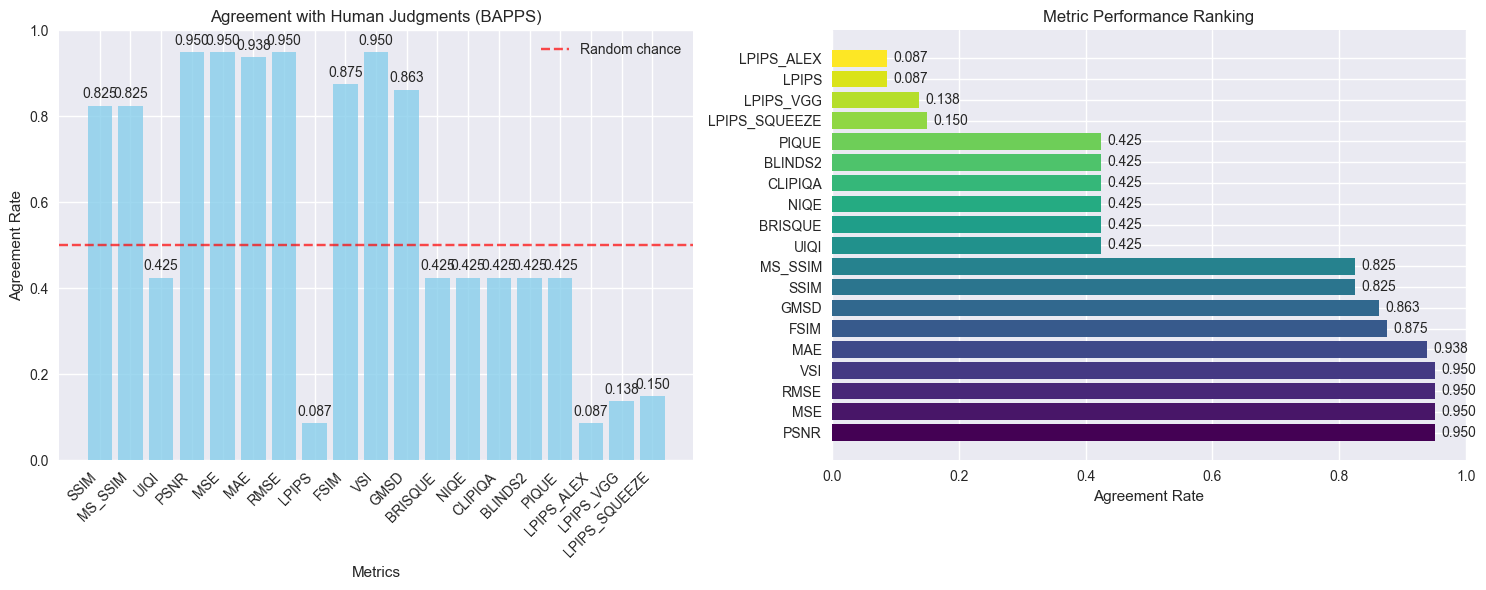


📊 Agreement Summary:


,Metric,Agreement_Rate
9,vsi,0.9500
3,psnr,0.9500
4,mse,0.9500
6,rmse,0.9500
5,mae,0.9375
8,fsim,0.8750
10,gmsd,0.8625
1,ms_ssim,0.8250
0,ssim,0.8250
2,uiqi,0.4250


In [8]:
# Visualize BAPPS Results

def analyze_bapps_agreement(results_df: pd.DataFrame) -> Dict[str, float]:
    """
    Analyze agreement between metrics and human judgments in BAPPS.
    
    Args:
        results_df: BAPPS evaluation results
    
    Returns:
        Dictionary of agreement rates
    """
    if results_df.empty:
        return {}
    
    print("📊 Analyzing BAPPS Agreement with Human Judgments")
    
    # Filter for clear preferences (exclude equal judgments)
    clear_prefs = results_df[results_df['human_judgment'] != 0.5].copy()
    
    if clear_prefs.empty:
        print("⚠️ No clear human preferences found")
        return {}
    
    print(f"📋 Analyzing {len(clear_prefs)} samples with clear preferences")
    
    # Human preference (True if prefers P0)
    human_prefers_p0 = clear_prefs['human_judgment'] < 0.5
    
    # Find preference columns
    pref_cols = [col for col in clear_prefs.columns if col.endswith('_prefers_p0')]
    
    agreement_rates = {}
    
    for col in pref_cols:
        metric_name = col.replace('_prefers_p0', '')
        metric_prefers_p0 = clear_prefs[col]
        
        if metric_prefers_p0.notna().sum() > 0:
            agreements = metric_prefers_p0 == human_prefers_p0
            agreement_rate = agreements.mean()
            agreement_rates[metric_name] = agreement_rate
            
            print(f"{metric_name.upper():12}: {agreement_rate:.3f} ({agreements.sum()}/{len(agreements)})")
    
    return agreement_rates

def plot_bapps_agreement(agreement_rates: Dict[str, float]):
    """
    Plot BAPPS agreement rates.
    
    Args:
        agreement_rates: Dictionary of metric agreement rates
    """
    if not agreement_rates:
        print("⚠️ No agreement data to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    metrics = list(agreement_rates.keys())
    rates = list(agreement_rates.values())
    
    bars = ax1.bar(range(len(metrics)), rates, color='skyblue', alpha=0.8)
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Agreement Rate')
    ax1.set_title('Agreement with Human Judgments (BAPPS)')
    ax1.set_xticks(range(len(metrics)))
    ax1.set_xticklabels([m.upper() for m in metrics], rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random chance')
    ax1.legend()
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{rate:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Ranking plot
    sorted_data = sorted(agreement_rates.items(), key=lambda x: x[1], reverse=True)
    sorted_metrics = [item[0].upper() for item in sorted_data]
    sorted_rates = [item[1] for item in sorted_data]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_metrics)))
    bars2 = ax2.barh(range(len(sorted_metrics)), sorted_rates, color=colors)
    ax2.set_yticks(range(len(sorted_metrics)))
    ax2.set_yticklabels(sorted_metrics)
    ax2.set_xlabel('Agreement Rate')
    ax2.set_title('Metric Performance Ranking')
    ax2.set_xlim(0, 1)
    
    # Add value labels
    for bar, rate in zip(bars2, sorted_rates):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{rate:.3f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Analyze and visualize BAPPS results
if not bapps_results.empty:
    print("\n" + "="*60)
    print("📊 BAPPS AGREEMENT ANALYSIS")
    print("="*60)
    
    agreement_rates = analyze_bapps_agreement(bapps_results)
    
    if agreement_rates:
        plot_bapps_agreement(agreement_rates)
        
        # Save results
        agreement_df = pd.DataFrame(list(agreement_rates.items()), 
                                  columns=['Metric', 'Agreement_Rate'])
        agreement_df = agreement_df.sort_values('Agreement_Rate', ascending=False)
        
        print("\n📊 Agreement Summary:")
        display(agreement_df)
else:
    print("⚠️ No BAPPS results available for analysis")


🔗 CORRELATION ANALYSIS

📊 BAPPS Metric Correlations:


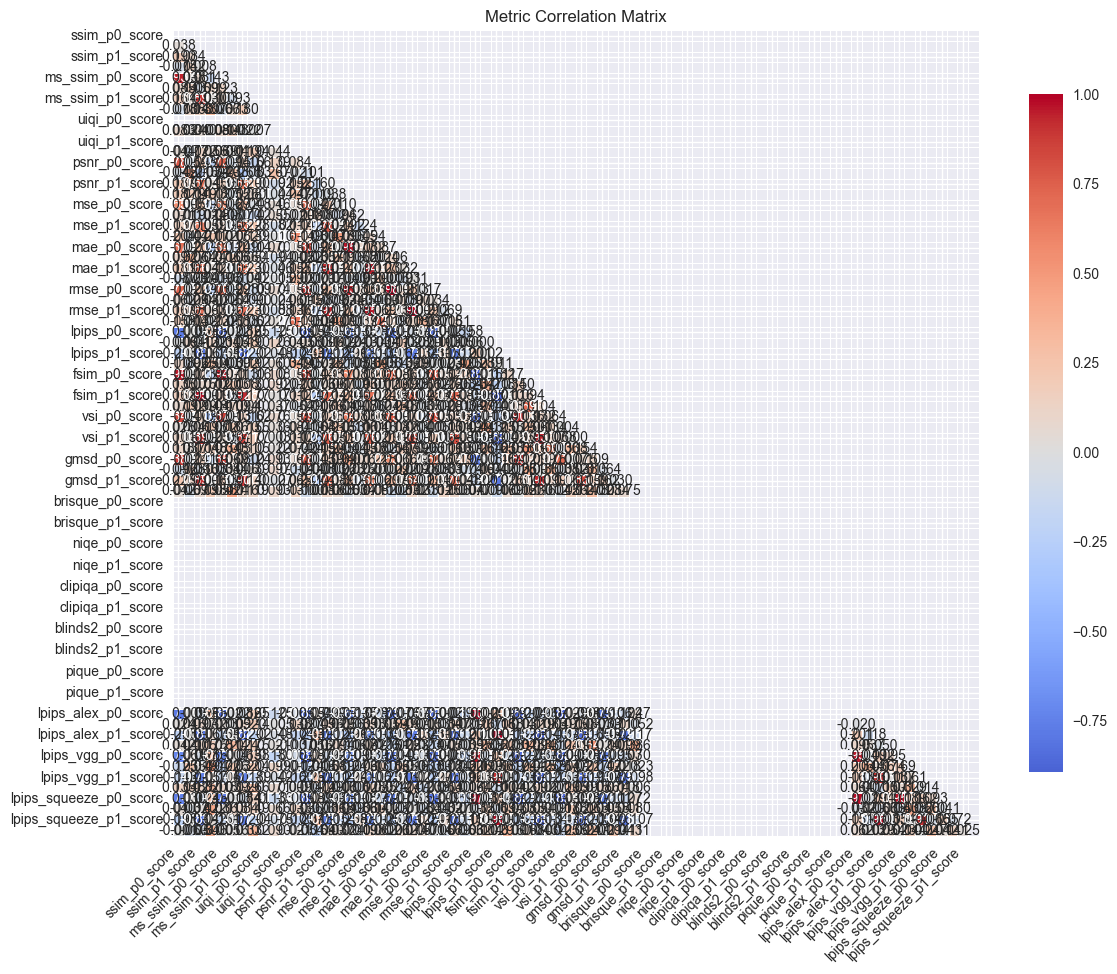


📊 LIVE-MD Correlations with MOS:


,Metric,Pearson_r,Pearson_p,Spearman_r,Spearman_p,N_samples
23,lpips_vgg_score,0.839382,1.086371e-120,0.883403,1.429256e-149,450
15,fsim_score,-0.823319,2.910875e-112,-0.873153,6.696888e-142,450
25,lpips_squeeze_score,0.815532,1.766477e-108,0.882853,3.842086e-149,450
21,lpips_alex_score,0.812624,4.114702e-107,0.874369,8.932774e-143,450
13,lpips_score,0.812624,4.114702e-107,0.874369,8.932774e-143,450
0,ssim_score,-0.802282,1.949848e-102,-0.871441,1.100754e-140,450
5,psnr_score,-0.799028,5.055048e-101,-0.772135,2.957302e-90,450
19,gmsd_score,-0.782628,2.837440e-94,-0.837355,1.412596e-119,450
2,ms_ssim_score,-0.776956,4.488298e-92,-0.875932,6.517361e-144,450
17,vsi_score,-0.769503,2.784578e-89,-0.862765,8.861703e-135,450


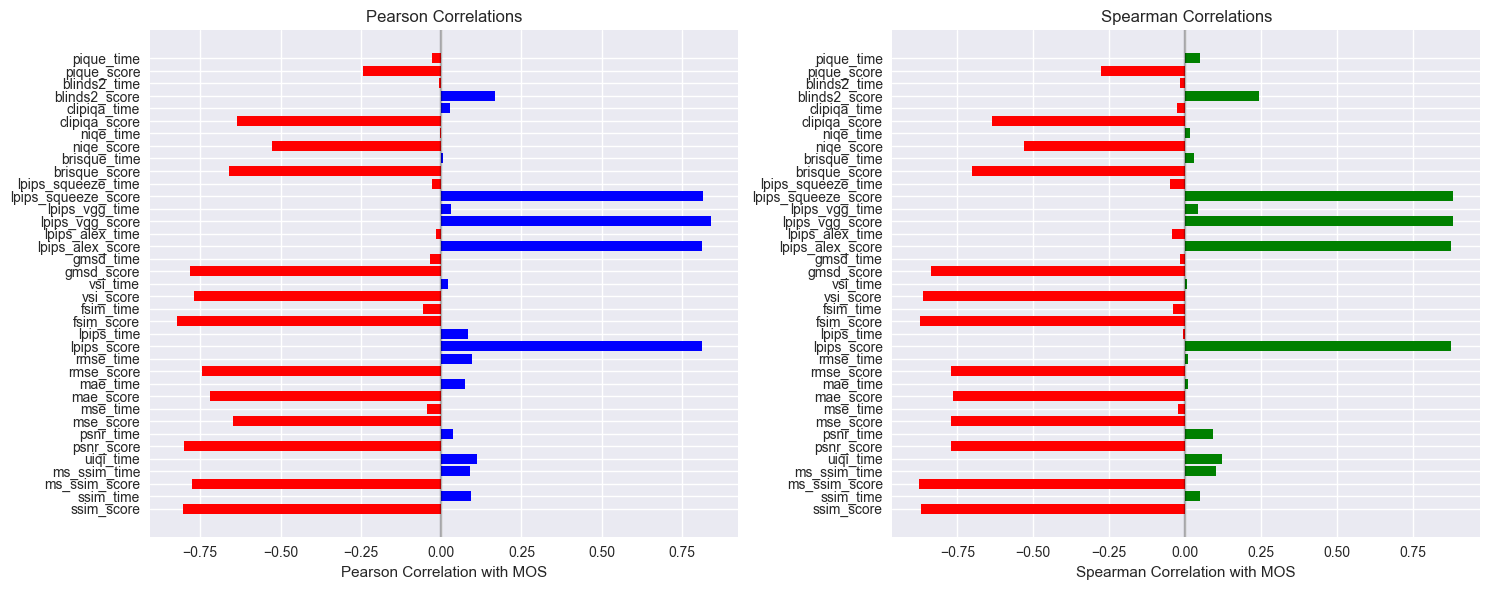

In [9]:
# Correlation Analysis

def compute_metric_correlations(results_df: pd.DataFrame, 
                              target_col: str = 'mos') -> pd.DataFrame:
    """
    Compute correlations between metrics and target variable.
    
    Args:
        results_df: Results DataFrame
        target_col: Target column for correlation
    
    Returns:
        DataFrame with correlation results
    """
    if results_df.empty or target_col not in results_df.columns:
        return pd.DataFrame()
    
    # Find metric columns (numeric columns excluding metadata)
    metric_cols = []
    for col in results_df.columns:
        if (results_df[col].dtype in ['float64', 'int64'] and 
            col not in ['sample_id', target_col] and
            not col.endswith('_prefers_p0')):
            metric_cols.append(col)
    
    if not metric_cols:
        return pd.DataFrame()
    
    correlations = []
    
    for metric in metric_cols:
        valid_data = results_df[[metric, target_col]].dropna()
        
        if len(valid_data) > 3:  # Need at least 4 points for correlation
            pearson_r, pearson_p = pearsonr(valid_data[metric], valid_data[target_col])
            spearman_r, spearman_p = spearmanr(valid_data[metric], valid_data[target_col])
            
            correlations.append({
                'Metric': metric,
                'Pearson_r': pearson_r,
                'Pearson_p': pearson_p,
                'Spearman_r': spearman_r,
                'Spearman_p': spearman_p,
                'N_samples': len(valid_data)
            })
    
    return pd.DataFrame(correlations)

def plot_correlation_heatmap(results_df: pd.DataFrame):
    """
    Plot correlation heatmap between metrics.
    
    Args:
        results_df: Results DataFrame
    """
    # Find metric columns
    metric_cols = []
    for col in results_df.columns:
        if (results_df[col].dtype in ['float64', 'int64'] and 
            col not in ['sample_id', 'mos', 'human_judgment'] and
            not col.endswith('_prefers_p0')):
            metric_cols.append(col)
    
    if len(metric_cols) < 2:
        print("⚠️ Not enough metrics for correlation analysis")
        return
    
    # Compute correlation matrix
    corr_matrix = results_df[metric_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                fmt='.3f')
    
    plt.title('Metric Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Perform correlation analysis
print("\n" + "="*60)
print("🔗 CORRELATION ANALYSIS")
print("="*60)

# BAPPS correlation analysis
if not bapps_results.empty:
    print("\n📊 BAPPS Metric Correlations:")
    plot_correlation_heatmap(bapps_results)

# LIVE-MD correlation analysis
if not live_md_results.empty and 'mos' in live_md_results.columns:
    print("\n📊 LIVE-MD Correlations with MOS:")
    live_md_corr = compute_metric_correlations(live_md_results, 'mos')
    
    if not live_md_corr.empty:
        display(live_md_corr.sort_values('Pearson_r', key=abs, ascending=False))
        
        # Plot correlations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Pearson correlations
        ax1.barh(live_md_corr['Metric'], live_md_corr['Pearson_r'], 
                color=['red' if x < 0 else 'blue' for x in live_md_corr['Pearson_r']])
        ax1.set_xlabel('Pearson Correlation with MOS')
        ax1.set_title('Pearson Correlations')
        ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Spearman correlations
        ax2.barh(live_md_corr['Metric'], live_md_corr['Spearman_r'],
                color=['red' if x < 0 else 'green' for x in live_md_corr['Spearman_r']])
        ax2.set_xlabel('Spearman Correlation with MOS')
        ax2.set_title('Spearman Correlations')
        ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()


🏆 COMPREHENSIVE PERFORMANCE ANALYSIS (with Timing)
Debug: LIVE-MD metric row for blinds2 Empty DataFrame
Columns: [Metric, Pearson_r, Pearson_p, Spearman_r, Spearman_p, N_samples]
Index: [] True
Debug: LIVE-MD metric row for blinds2_score            Metric  Pearson_r  Pearson_p  Spearman_r    Spearman_p  N_samples
33  blinds2_score   0.167236   0.000367    0.243975  1.601401e-07        450 False
Debug: LIVE-MD metric row for blinds2_time           Metric  Pearson_r  Pearson_p  Spearman_r  Spearman_p  N_samples
34  blinds2_time   -0.00535   0.909898   -0.015952    0.735766        450 False
Debug: LIVE-MD metric row for brisque Empty DataFrame
Columns: [Metric, Pearson_r, Pearson_p, Spearman_r, Spearman_p, N_samples]
Index: [] True
Debug: LIVE-MD metric row for brisque_score            Metric  Pearson_r     Pearson_p  Spearman_r    Spearman_p  \
27  brisque_score   -0.65957  1.617655e-57   -0.702816  2.933531e-68   

    N_samples  
27        450   False
Debug: LIVE-MD metric row for br

,Metric,BAPPS_Agreement,LIVE_MD_Pearson_Abs,LIVE_MD_Spearman_Abs,Avg_Computation_Time_s,Category,Type,Overall_Performance_Score
46,rmse,0.9500,NaN,NaN,0.000102,signal,full_reference,0.475000
43,psnr,0.9500,NaN,NaN,0.000764,signal,full_reference,0.475000
34,mse,0.9500,NaN,NaN,0.000137,signal,full_reference,0.475000
54,vsi,0.9500,NaN,NaN,0.057009,feature,full_reference,0.475000
27,mae,0.9375,NaN,NaN,0.000328,signal,full_reference,0.468750
9,fsim,0.8750,NaN,NaN,0.086551,feature,full_reference,0.437500
12,gmsd,0.8625,NaN,NaN,0.005536,feature,full_reference,0.431250
25,lpips_vgg_score,NaN,0.839382,0.883403,NaN,unknown,unknown,0.419691
49,ssim,0.8250,NaN,NaN,0.037714,structural,full_reference,0.412500
31,ms_ssim,0.8250,NaN,NaN,0.045446,structural,full_reference,0.412500


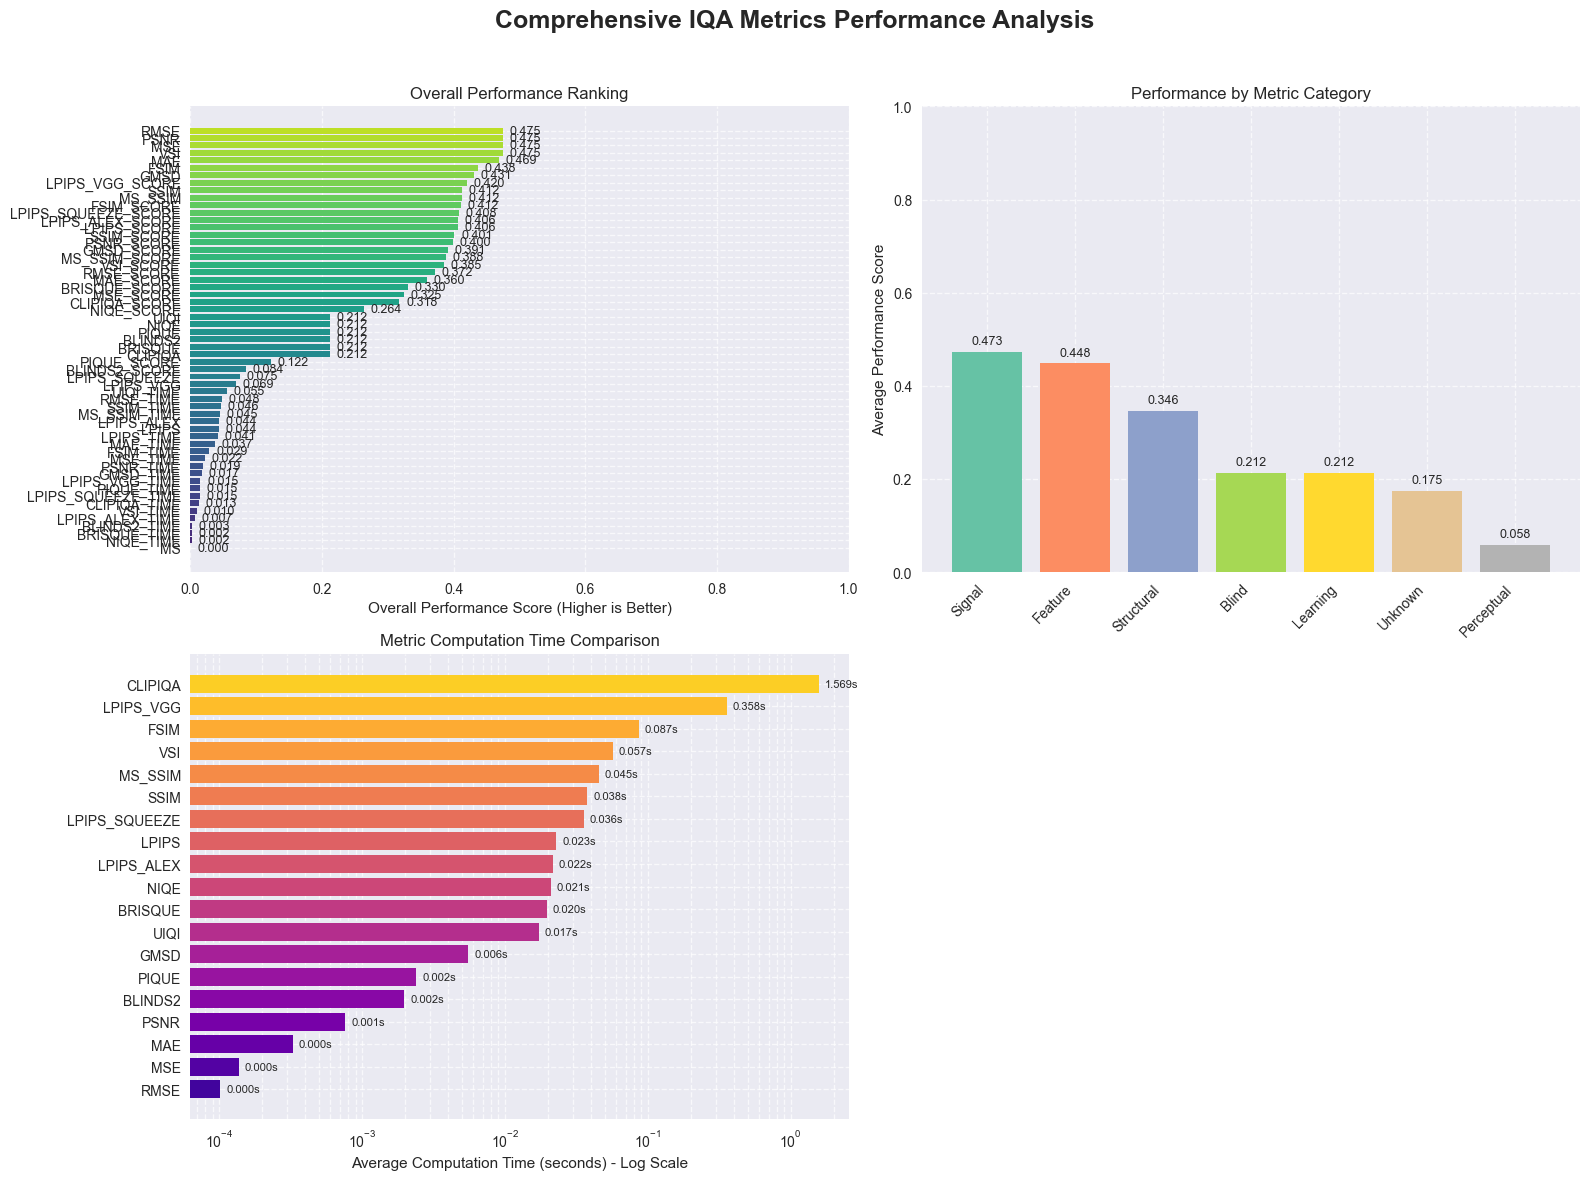


💾 Performance summary saved to: IQA_Performance_Summary.csv


In [ ]:
# Comparative Performance Analysis with Computation Time

def create_performance_summary(bapps_agreement: Dict[str, float] = None,
                             live_md_corr: pd.DataFrame = None, # Expected to have 'Metric', 'Pearson_r', 'Spearman_r'
                             bapps_results_df: pd.DataFrame = None, # Raw BAPPS results for time
                             live_md_results_df: pd.DataFrame = None, # Raw LIVE_MD results for time
                             custom_results_df: pd.DataFrame = None # Raw custom results for time
                             ) -> pd.DataFrame:
    """
    Create comprehensive performance summary including average computation time.
    
    Args:
        bapps_agreement: BAPPS agreement rates {metric: rate}
        live_md_corr: LIVE-MD correlation results (DataFrame) Metric, Pearson_r, Pearson_p, Spearman_r, Spearman_p, N_samples
        bapps_results_df: DataFrame from evaluate_bapps_dataset()
        live_md_results_df: DataFrame from evaluate_live_md_dataset()
        custom_results_df: DataFrame from custom dataset evaluation
    
    Returns:
        Performance summary DataFrame with scores and avg computation times.
    """
    summary_data = []
    all_metrics = set()

    # Gather all unique metric names from all sources
    if bapps_agreement:
        all_metrics.update(bapps_agreement.keys())
    if live_md_corr is not None and not live_md_corr.empty:
        all_metrics.update(live_md_corr['Metric'].tolist())
    
    # Extract metrics from detailed results DataFrames to ensure all evaluated metrics are included
    # for computation time analysis, even if they don't appear in agreement/correlation summaries.
    metric_time_columns = []
    if bapps_results_df is not None and not bapps_results_df.empty:
        metric_time_columns.extend([col for col in bapps_results_df.columns if '_p0_score' in col or '_p1_score' in col])
    if live_md_results_df is not None and not live_md_results_df.empty:
        metric_time_columns.extend([col for col in live_md_results_df.columns if col.endswith('_score')])
    if custom_results_df is not None and not custom_results_df.empty and 'metric' in custom_results_df.columns:
        all_metrics.update(custom_results_df['metric'].unique())

    # Clean up metric names from DataFrame columns
    for mt_col in metric_time_columns: 
        all_metrics.add(mt_col.split('_')[0])


    for metric in sorted(list(all_metrics)): # Sort for consistent order
        row = {'Metric': metric}
        
        # BAPPS performance
        row['BAPPS_Agreement'] = bapps_agreement.get(metric, np.nan) if bapps_agreement else np.nan
        
        # LIVE-MD performance
        if live_md_corr is not None and not live_md_corr.empty:
            metric_row_live = live_md_corr[live_md_corr['Metric'] == metric]
            print(f"Debug: LIVE-MD metric row for {metric} {metric_row_live} {metric_row_live.empty}")
            if not metric_row_live.empty:
                row['LIVE_MD_Pearson_Abs'] = abs(metric_row_live['Pearson_r'].iloc[0])
                row['LIVE_MD_Spearman_Abs'] = abs(metric_row_live['Spearman_r'].iloc[0])
            else:
                row['LIVE_MD_Pearson_Abs'] = np.nan
                row['LIVE_MD_Spearman_Abs'] = np.nan
        else:
            row['LIVE_MD_Pearson_Abs'] = np.nan
            row['LIVE_MD_Spearman_Abs'] = np.nan

        # Average Computation Time
        # Collect all time values for the current metric from all datasets
        all_times_for_metric = []
        # BAPPS times (average of p0 and p1 times for each sample)
        if bapps_results_df is not None and not bapps_results_df.empty:
            if f'{metric}_p0_time' in bapps_results_df.columns and f'{metric}_p1_time' in bapps_results_df.columns:
                times_p0 = bapps_results_df[f'{metric}_p0_time'].dropna()
                times_p1 = bapps_results_df[f'{metric}_p1_time'].dropna()
                all_times_for_metric.extend(times_p0)
                all_times_for_metric.extend(times_p1)

        # LIVE-MD times
        if live_md_results_df is not None and not live_md_results_df.empty:
            if f'{metric}_time' in live_md_results_df.columns:
                 all_times_for_metric.extend(live_md_results_df[f'{metric}_time'].dropna())

        # Custom dataset times
        if custom_results_df is not None and not custom_results_df.empty and 'metric' in custom_results_df.columns and 'time' in custom_results_df.columns:
            custom_metric_times = custom_results_df[custom_results_df['metric'] == metric]['time'].dropna()
            all_times_for_metric.extend(custom_metric_times)
        
        if all_times_for_metric:
            row['Avg_Computation_Time_s'] = np.mean([t for t in all_times_for_metric if pd.notna(t) and isinstance(t, (int, float)) and t >= 0])
        else:
            row['Avg_Computation_Time_s'] = np.nan
            
        # Get metric category and type
        metric_info = iqa.get_metric_info().get(metric, {}) # Assuming 'iqa' is global
        row['Category'] = metric_info.get('category', 'unknown')
        row['Type'] = metric_info.get('type', 'unknown') # FR or NR
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Compute overall performance score (example: average of BAPPS Agreement and LIVE-MD Pearson)
    # This can be customized. We use absolute Pearson for scoring.
    overall_score_components = []
    if 'BAPPS_Agreement' in summary_df.columns and summary_df['BAPPS_Agreement'].notna().any():
        overall_score_components.append(summary_df['BAPPS_Agreement'].fillna(0))
    if 'LIVE_MD_Pearson_Abs' in summary_df.columns and summary_df['LIVE_MD_Pearson_Abs'].notna().any(): # Use absolute Pearson
        overall_score_components.append(summary_df['LIVE_MD_Pearson_Abs'].fillna(0))

    if overall_score_components:
        summary_df['Overall_Performance_Score'] = sum(overall_score_components) / len(overall_score_components)
    else:
        summary_df['Overall_Performance_Score'] = np.nan
        
    return summary_df.sort_values('Overall_Performance_Score', ascending=False, na_position='last')


def plot_performance_comparison(summary_df: pd.DataFrame):
    """
    Plot comprehensive performance comparison, including computation time.
    """
    if summary_df.empty:
        print("⚠️ No performance data to plot")
        return
    
    # Determine number of rows for subplots based on available data
    num_plots = 2 # Start with Overall Performance and Category Performance
    if 'BAPPS_Agreement' in summary_df.columns and 'LIVE_MD_Pearson_Abs' in summary_df.columns and \
       summary_df[['BAPPS_Agreement', 'LIVE_MD_Pearson_Abs']].notna().all(axis=1).any():
        num_plots += 1 # Add Cross-Dataset plot
    if 'Avg_Computation_Time_s' in summary_df.columns and summary_df['Avg_Computation_Time_s'].notna().any():
        num_plots += 1 # Add Computation Time plot
        
    num_rows = (num_plots + 1) // 2 # 2 plots per row
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows))
    axes = axes.flatten() # Flatten to easily index
    plot_idx = 0

    fig.suptitle('Comprehensive IQA Metrics Performance Analysis', fontsize=18, fontweight='bold')
    
    # 1. Overall performance ranking
    ax = axes[plot_idx]
    plot_idx +=1
    valid_overall = summary_df.dropna(subset=['Overall_Performance_Score']).sort_values('Overall_Performance_Score', ascending=True) # Ascending for barh
    if not valid_overall.empty:
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(valid_overall)))
        bars = ax.barh(valid_overall['Metric'].str.upper(), valid_overall['Overall_Performance_Score'], color=colors)
        ax.set_xlabel('Overall Performance Score (Higher is Better)')
        ax.set_title('Overall Performance Ranking')
        ax.set_xlim(0, max(1, valid_overall['Overall_Performance_Score'].max() * 1.1)) # Adjust xlim
        for i, (bar, score) in enumerate(zip(bars, valid_overall['Overall_Performance_Score'])):
            ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9)
    else:
        ax.text(0.5, 0.5, "No overall performance data", ha='center', va='center')
    ax.grid(True, linestyle='--', alpha=0.7)

    # 2. Performance by category
    ax = axes[plot_idx]
    plot_idx +=1
    if 'Category' in summary_df.columns and 'Overall_Performance_Score' in summary_df.columns:
        category_perf = summary_df.groupby('Category')['Overall_Performance_Score'].mean().sort_values(ascending=False)
        if not category_perf.empty:
            category_colors = plt.cm.Set2(np.linspace(0, 1, len(category_perf)))
            bars = ax.bar(category_perf.index.str.title(), category_perf.values, color=category_colors)
            ax.set_ylabel('Average Performance Score')
            ax.set_title('Performance by Metric Category')
            ax.set_ylim(0, max(1, category_perf.max() * 1.1))
            ax.tick_params(axis='x', rotation=45)
            ax.set_xticklabels(category_perf.index.str.title(), ha='right')
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(0.5, 0.5, "No category performance data", ha='center', va='center')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 3. BAPPS vs LIVE-MD performance scatter (if data exists)
    if 'BAPPS_Agreement' in summary_df.columns and 'LIVE_MD_Pearson_Abs' in summary_df.columns and \
       summary_df[['BAPPS_Agreement', 'LIVE_MD_Pearson_Abs']].notna().all(axis=1).any():
        ax = axes[plot_idx]
        plot_idx +=1
        valid_scatter = summary_df.dropna(subset=['BAPPS_Agreement', 'LIVE_MD_Pearson_Abs'])
        if not valid_scatter.empty:
            scatter_colors = plt.cm.coolwarm(np.linspace(0,1,len(valid_scatter['Metric'])))
            ax.scatter(valid_scatter['BAPPS_Agreement'], valid_scatter['LIVE_MD_Pearson_Abs'], 
                        c=scatter_colors, s=100, alpha=0.8, edgecolors='w', linewidth=0.5)
            for i, row in valid_scatter.iterrows():
                ax.annotate(row['Metric'].upper(), 
                           (row['BAPPS_Agreement'], row['LIVE_MD_Pearson_Abs']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9)
            ax.set_xlabel('BAPPS Agreement Rate')
            ax.set_ylabel('LIVE-MD Correlation (|Pearson r| with MOS)')
            ax.set_title('Cross-Dataset Performance Consistency')
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5) # Diagonal line for reference
            ax.set_xlim(left=max(0, valid_scatter['BAPPS_Agreement'].min() - 0.1), right=min(1, valid_scatter['BAPPS_Agreement'].max() + 0.1))
            ax.set_ylim(bottom=max(0, valid_scatter['LIVE_MD_Pearson_Abs'].min() - 0.1), top=min(1, valid_scatter['LIVE_MD_Pearson_Abs'].max() + 0.1))
        else:
            ax.text(0.5, 0.5, "Not enough data for scatter plot", ha='center', va='center')
        ax.grid(True, linestyle='--', alpha=0.7)

    # 4. Average Computation Time Comparison (if data exists)
    if 'Avg_Computation_Time_s' in summary_df.columns and summary_df['Avg_Computation_Time_s'].notna().any():
        ax = axes[plot_idx]
        plot_idx +=1
        time_summary = summary_df[['Metric', 'Avg_Computation_Time_s']].dropna().sort_values('Avg_Computation_Time_s', ascending=True) # Ascending for barh
        if not time_summary.empty:
            time_colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(time_summary)))
            bars = ax.barh(time_summary['Metric'].str.upper(), time_summary['Avg_Computation_Time_s'], color=time_colors)
            ax.set_xlabel('Average Computation Time (seconds) - Log Scale')
            ax.set_title('Metric Computation Time Comparison')
            ax.set_xscale('log') # Use log scale for time due to potential large variance
            # Add text labels for time
            for i, (bar, time_val) in enumerate(zip(bars, time_summary['Avg_Computation_Time_s'])):
                 ax.text(time_val * 1.1, i, f'{time_val:.3f}s', va='center', fontsize=8) # Adjust position for log scale
        else:
            ax.text(0.5, 0.5, "No computation time data", ha='center', va='center')
        ax.grid(True, linestyle='--', alpha=0.7,which="both")


    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

# --- Main execution flow for this cell ---
print("\n" + "="*60)
print("🏆 COMPREHENSIVE PERFORMANCE ANALYSIS (with Timing)")
print("="*60)

# Gather performance data
# BAPPS agreement rates (assuming 'agreement_rates' is calculated in a previous cell)
perf_bapps_agreement = agreement_rates if 'agreement_rates' in locals() and isinstance(agreement_rates, dict) else {}

# LIVE-MD correlations (assuming 'live_md_corr' DataFrame is from a previous cell)
perf_live_md_corr_df = live_md_corr if 'live_md_corr' in locals() and isinstance(live_md_corr, pd.DataFrame) else pd.DataFrame()

# Raw results DataFrames (should be defined from their respective evaluation cells)
bapps_results_for_summary = bapps_results if 'bapps_results' in locals() and isinstance(bapps_results, pd.DataFrame) else pd.DataFrame()
live_md_results_for_summary = live_md_results if 'live_md_results' in locals() and isinstance(live_md_results, pd.DataFrame) else pd.DataFrame()
custom_results_for_summary = custom_results_df if 'custom_results_df' in locals() and isinstance(custom_results_df, pd.DataFrame) else pd.DataFrame()


# Create performance summary, now including computation time
performance_summary = create_performance_summary(
    bapps_agreement=perf_bapps_agreement,
    live_md_corr=perf_live_md_corr_df,
    bapps_results_df=bapps_results_for_summary,
    live_md_results_df=live_md_results_for_summary,
    custom_results_df=custom_results_for_summary
)

if not performance_summary.empty:
    print("\n📊 Performance Summary Table (incl. Avg. Computation Time):")
    display(performance_summary)
    
    # Plot comprehensive comparison
    plot_performance_comparison(performance_summary)
    
    # Save summary to CSV
    summary_csv_path = 'IQA_Performance_Summary.csv'
    try:
        performance_summary.to_csv(summary_csv_path, index=False)
        print(f"\n💾 Performance summary saved to: {summary_csv_path}")
    except Exception as e:
        print(f"\n⚠️ Error saving performance summary: {e}")
else:
    print("⚠️ No performance data available for summary table or plotting.")

# The old block for 'processed_custom_data_summary_input_df' is removed as custom data
# is now directly passed to create_performance_summary via 'custom_results_df'.

## Part 3: Custom Dataset Integration and Programmatic Distortion Analysis

This section focuses on integrating and analyzing custom image datasets located in the `./images` directory. Since these datasets only contain original images, we will programmatically generate various distortions and then evaluate IQA metrics.

In [12]:
import os
import glob
from PIL import Image
import numpy as np
import skimage.io
from skimage.util import random_noise
from skimage.transform import resize
from io import BytesIO
import cv2 # OpenCV for Gaussian Blur

# Define the path to your custom datasets
custom_dataset_base_path = './images/'

# Function to discover image files in custom dataset subdirectories
def find_custom_images(base_path):
    """
    Finds all image files (jpg, png, tif, bmp) in subdirectories of base_path.
    Returns a dictionary where keys are subdirectory names (dataset names)
    and values are lists of image file paths.
    """
    datasets = {}
    if not os.path.isdir(base_path):
        print(f"Error: Custom dataset base path '{base_path}' not found.")
        return datasets

    for dataset_name in os.listdir(base_path):
        dataset_dir = os.path.join(base_path, dataset_name)
        if os.path.isdir(dataset_dir):
            image_files = []
            for ext in ('*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff', '*.bmp'):
                image_files.extend(glob.glob(os.path.join(dataset_dir, ext)))
            if image_files:
                datasets[dataset_name] = sorted(image_files)
                print(f"Found {len(image_files)} images in custom dataset: {dataset_name}")
            else:
                print(f"No images found in custom dataset directory: {dataset_dir}")
    return datasets

custom_image_paths = find_custom_images(custom_dataset_base_path)

# Display a few found images from the first dataset for verification
if custom_image_paths:
    first_dataset_name = list(custom_image_paths.keys())[0]
    print(f"\nExample images from '{first_dataset_name}':")
    for img_path in custom_image_paths[first_dataset_name][:2]: # Show first 2 images
        print(img_path)
        # display(Image.open(img_path).resize((128,128))) # Optional: display images if running in a rich frontend
else:
    print("No custom datasets found or loaded.")

Found 10 images in custom dataset: generated
Found 12 images in custom dataset: Skin
Found 9 images in custom dataset: ElectronMicroscope
Found 18 images in custom dataset: X-ray
Found 13 images in custom dataset: lungMRI
Found 22 images in custom dataset: MRI
Found 13 images in custom dataset: text
Found 10 images in custom dataset: satilite
Found 6 images in custom dataset: CFD

Example images from 'generated':
./images/generated/0002.jpg
./images/generated/0026.jpg


### Distortion Functions

We will define functions to apply common image distortions. These will be used to generate distorted versions of the original images from our custom datasets.

In [13]:
# Distortion Functions

def apply_gaussian_blur(image_path, kernel_size):
    """Applies Gaussian blur to an image."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    blurred_img = cv2.GaussianBlur(img_rgb, (kernel_size, kernel_size), 0)
    return Image.fromarray(blurred_img)

def apply_gaussian_noise(image_path, var):
    """Applies Gaussian noise to an image."""
    img = skimage.io.imread(image_path) / 255.0 # Read and normalize to [0,1]
    noisy_img = random_noise(img, mode='gaussian', var=var)
    return Image.fromarray((noisy_img * 255).astype(np.uint8))

def apply_jpeg_compression(image_path, quality):
    """Applies JPEG compression to an image."""
    img = Image.open(image_path).convert('RGB')
    buffer = BytesIO()
    img.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

# Example: Load one image and apply distortions (for testing the functions)
if custom_image_paths and list(custom_image_paths.values()):
    example_image_path = list(custom_image_paths.values())[0][0]
    print(f"Applying distortions to: {example_image_path}")

    try:
        original_pil = Image.open(example_image_path).resize((256,256))
        blurred_pil = apply_gaussian_blur(example_image_path, kernel_size=15).resize((256,256))
        noisy_pil = apply_gaussian_noise(example_image_path, var=0.05).resize((256,256))
        jpeg_pil = apply_jpeg_compression(example_image_path, quality=20).resize((256,256))

        print("Original vs. Distorted examples (if display is available):")
        # fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Requires matplotlib
        # axes[0].imshow(original_pil); axes[0].set_title('Original'); axes[0].axis('off')
        # axes[1].imshow(blurred_pil); axes[1].set_title('Blurred (15x15)'); axes[1].axis('off')
        # axes[2].imshow(noisy_pil); axes[2].set_title('Noise (var=0.05)'); axes[2].axis('off')
        # axes[3].imshow(jpeg_pil); axes[3].set_title('JPEG (q=20)'); axes[3].axis('off')
        # plt.show()
        print("Distortion functions seem to be working. Further visualization would require matplotlib.")
    except Exception as e:
        print(f"Error applying example distortions: {e}")
else:
    print("No images found to test distortion functions.")


Applying distortions to: ./images/generated/0002.jpg
Original vs. Distorted examples (if display is available):
Distortion functions seem to be working. Further visualization would require matplotlib.


### Metric Evaluation on Custom Datasets with Programmatic Distortions

Now, we will use the `IQAMetrics` evaluator (initialized earlier or re-initialize if needed) to assess the quality of the original and programmatically distorted images from our custom datasets.

In [18]:
import pandas as pd
import tempfile
import time  # Ensure time is imported

# Ensure the IQAMetrics class is available
# This might have been done in a previous cell. If not, uncomment and adjust path as needed.
# import sys
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Example path adjustment
# from iqa_metrics import IQAMetrics

# Use the existing 'iqa' instance if available, or 'iqa_evaluator_custom' if specifically defined for this.
# For consistency, let's assume 'iqa' is the primary evaluator instance.
# If 'iqa_evaluator_custom' was intentionally separate, ensure it's initialized.
from iqa_metrics import IQAMetrics  # Make sure this import works
if 'iqa' not in locals() or iqa is None:
    print("⚠️ Main 'iqa' evaluator not found. Initializing a new one for custom datasets.")
    # This assumes IQAMetrics is importable
    from iqa_metrics import IQAMetrics  # Make sure this import works
    iqa_custom_eval = IQAMetrics(device='auto')  # Use a distinct name if 'iqa' is used elsewhere
else:
    iqa_custom_eval = iqa  # Use the global/notebook-wide 'iqa' instance

# Define distortion types and levels
distortion_params = {
    'gaussian_blur': [5, 15, 25],  # Kernel sizes
    'gaussian_noise': [0.01, 0.05, 0.1],  # Variances
    'jpeg_compression': [75, 50, 20]  # Quality levels
}

custom_results_list = []

# Define metrics to run on custom dataset (can be a mix of FR and NR)
# Users can customize this list
custom_fr_metrics = iqa.get_available_metrics('full_reference')
custom_nr_metrics = iqa.get_available_metrics('no_reference')


# Create a temporary directory to store distorted images
with tempfile.TemporaryDirectory(prefix='iqa_distorted_') as temp_dir:
    print(f"Created temporary directory for distorted images: {temp_dir}")

    for dataset_name, image_paths in custom_image_paths.items():
        print(f"\nProcessing dataset: {dataset_name} ({len(image_paths)} images)")
        for original_img_path in tqdm(image_paths, desc=f"Dataset {dataset_name}"):
            original_img_name = os.path.basename(original_img_path)
            # print(f"  Processing original: {original_img_name}") # tqdm provides progress

            # Evaluate No-Reference metrics on the original image
            if custom_nr_metrics and iqa.validate_image_path(original_img_path):
                # evaluate_single_image returns Dict[str, {'score': float, 'time': float}]
                nr_original_scores_data = iqa.evaluate_no_reference(original_img_path, custom_nr_metrics) # MODIFIED
                for metric_name, data in nr_original_scores_data.items():
                    custom_results_list.append({
                        'dataset': dataset_name,
                        'original_image': original_img_name,
                        'distortion_type': 'original',
                        'distortion_level': 0,
                        'distorted_image_path': original_img_path,  # Original is its own "distorted" version here
                        'metric': metric_name,
                        'score': data.get('score', np.nan),
                        'time': data.get('time', np.nan),
                        'metric_type': 'NR'
                    })

            # Apply distortions and evaluate metrics
            for distortion_type, levels in distortion_params.items():
                for level in levels:
                    distorted_img_pil = None
                    # Create a unique filename for the distorted image
                    base, ext = os.path.splitext(original_img_name)
                    distorted_img_filename = f"{base}_{distortion_type}_{level}{ext}"
                    distorted_img_path = os.path.join(temp_dir, distorted_img_filename)

                    try:
                        if distortion_type == 'gaussian_blur':
                            distorted_img_pil = apply_gaussian_blur(original_img_path, kernel_size=level)
                        elif distortion_type == 'gaussian_noise':
                            distorted_img_pil = apply_gaussian_noise(original_img_path, var=level)
                        elif distortion_type == 'jpeg_compression':
                            distorted_img_pil = apply_jpeg_compression(original_img_path, quality=level)
                        
                        if distorted_img_pil:
                            distorted_img_pil.save(distorted_img_path)

                            # Evaluate Full-Reference metrics
                            if custom_fr_metrics and iqa.validate_image_path(original_img_path) and iqa.validate_image_path(distorted_img_path):
                                fr_scores_data = iqa.evaluate_pair(original_img_path, distorted_img_path, custom_fr_metrics) # MODIFIED
                                for metric_name, data in fr_scores_data.items():
                                    custom_results_list.append({
                                        'dataset': dataset_name,
                                        'original_image': original_img_name,
                                        'distortion_type': distortion_type,
                                        'distortion_level': level,
                                        'distorted_image_path': distorted_img_path,
                                        'metric': metric_name,
                                        'score': data.get('score', np.nan),
                                        'time': data.get('time', np.nan),
                                        'metric_type': 'FR'
                                    })

                            # Evaluate No-Reference metrics on the distorted image
                            if custom_nr_metrics and iqa.validate_image_path(distorted_img_path):
                                nr_distorted_scores_data = iqa.evaluate_no_reference(distorted_img_path, custom_nr_metrics) # MODIFIED
                                for metric_name, data in nr_distorted_scores_data.items():
                                    custom_results_list.append({
                                        'dataset': dataset_name,
                                        'original_image': original_img_name,
                                        'distortion_type': distortion_type,
                                        'distortion_level': level,
                                        'distorted_image_path': distorted_img_path,
                                        'metric': metric_name,
                                        'score': data.get('score', np.nan),
                                        'time': data.get('time', np.nan),
                                        'metric_type': 'NR'
                                    })
                        # else: # This case should ideally not happen if distortion functions are robust
                            # print(f"    Failed to generate distortion {distortion_type} level {level} for {original_img_name}")

                    except Exception as e:
                        print(f"    Error processing {distortion_type} level {level} for {original_img_name} (path: {original_img_path}): {e}")


# Convert results to DataFrame
custom_results_df = pd.DataFrame(custom_results_list)
print("\nCustom dataset evaluation complete.")
print(f"Collected {len(custom_results_df)} results (scores and times).")

if not custom_results_df.empty:
    print("\nFirst 5 results from custom dataset evaluation:")
    display(custom_results_df.head())
    # print(custom_results_df.info()) # For debugging
else:
    print("\nNo results collected from custom dataset evaluation. Check for errors above.")

# Clean up sys.path if it was modified for iqa_metrics import, though it's better to manage PYTHONPATH or install the module
# if os.path.abspath(os.path.join(os.getcwd(), '..')) in sys.path:
#    sys.path.remove(os.path.abspath(os.path.join(os.getcwd(), '..')))

Created temporary directory for distorted images: /var/folders/kv/dhtpsyc96bxbf6h3xtp79xnc0000gn/T/iqa_distorted_djlu6jvj

Processing dataset: generated (10 images)


Dataset generated: 100%|██████████| 10/10 [05:05<00:00, 30.51s/it]



Processing dataset: Skin (12 images)


Dataset Skin: 100%|██████████| 12/12 [05:51<00:00, 29.28s/it]



Processing dataset: ElectronMicroscope (9 images)


Dataset ElectronMicroscope: 100%|██████████| 9/9 [04:41<00:00, 31.29s/it]



Processing dataset: X-ray (18 images)


Dataset X-ray: 100%|██████████| 18/18 [08:48<00:00, 29.38s/it]



Processing dataset: lungMRI (13 images)


Dataset lungMRI: 100%|██████████| 13/13 [07:06<00:00, 32.78s/it]



Processing dataset: MRI (22 images)


Dataset MRI: 100%|██████████| 22/22 [11:29<00:00, 31.33s/it]



Processing dataset: text (13 images)


Dataset text:  31%|███       | 4/13 [02:02<04:37, 30.83s/it]

    Error processing gaussian_noise level 0.01 for 18.jpg (path: ./images/text/18.jpg): cannot write mode RGBA as JPEG
    Error processing gaussian_noise level 0.05 for 18.jpg (path: ./images/text/18.jpg): cannot write mode RGBA as JPEG
    Error processing gaussian_noise level 0.1 for 18.jpg (path: ./images/text/18.jpg): cannot write mode RGBA as JPEG


Dataset text:  69%|██████▉   | 9/13 [04:24<01:57, 29.36s/it]

    Error processing gaussian_blur level 5 for 31.jpg (path: ./images/text/31.jpg): OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

    Error processing gaussian_blur level 15 for 31.jpg (path: ./images/text/31.jpg): OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

    Error processing gaussian_blur level 25 for 31.jpg (path: ./images/text/31.jpg): OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

    Error processing gaussian_noise level 0.01 for 31.jpg (path: ./images/text/31.jpg): Cannot handle this data type: (1, 1, 482, 3), |u1
    Error processing

Dataset text: 100%|██████████| 13/13 [06:10<00:00, 28.48s/it]



Processing dataset: satilite (10 images)


Dataset satilite: 100%|██████████| 10/10 [05:46<00:00, 34.67s/it]



Processing dataset: CFD (6 images)


Dataset CFD: 100%|██████████| 6/6 [03:26<00:00, 34.41s/it]



Custom dataset evaluation complete.
Collected 19717 results (scores and times).

First 5 results from custom dataset evaluation:


,dataset,original_image,distortion_type,distortion_level,distorted_image_path,metric,score,time,metric_type
0,generated,0002.jpg,original,0.0,./images/generated/0002.jpg,brisque,0.910057,0.141564,NR
1,generated,0002.jpg,original,0.0,./images/generated/0002.jpg,niqe,0.887375,0.040107,NR
2,generated,0002.jpg,original,0.0,./images/generated/0002.jpg,clipiqa,0.757074,2.622122,NR
3,generated,0002.jpg,original,0.0,./images/generated/0002.jpg,blinds2,0.064719,0.012880,NR
4,generated,0002.jpg,original,0.0,./images/generated/0002.jpg,pique,0.147902,0.003460,NR


### Analysis and Visualization of Custom Dataset Results

This section will be used to analyze the IQA scores obtained from the custom datasets and their programmatically generated distortions. We can compare how different metrics respond to controlled changes in image quality.

In [19]:
# Placeholder for Custom Dataset Analysis and Visualization
# Example: Group by distortion type and metric, then plot average scores

if not custom_results_df.empty:
    # Basic summary
    print("\nSummary of results by distortion type and metric (average scores):")
    summary_custom = custom_results_df.groupby(['distortion_type', 'metric'])['score'].mean().unstack()
    print(summary_custom)
    
    # Further analysis and plotting can be added here.
    # For example, using matplotlib or seaborn to visualize:
    # - Score distributions for each metric under different distortions.
    # - Comparison of FR and NR metrics for the same distorted images.
    # - Metric sensitivity to increasing distortion levels.
    
    # Example: Plot average FR scores for a specific metric across distortion levels
    # import matplotlib.pyplot as plt
    # import seaborn as sns
    
    # metric_to_plot = 'ssim' # Example metric
    # fr_results_to_plot = custom_results_df[(custom_results_df['metric'] == metric_to_plot) & (custom_results_df['metric_type'] == 'FR')]
    
    # if not fr_results_to_plot.empty:
    #     plt.figure(figsize=(12, 6))
    #     sns.lineplot(data=fr_results_to_plot, x='distortion_level', y='score', hue='distortion_type', marker='o')
    #     plt.title(f'{metric_to_plot.upper()} vs. Distortion Level (Custom Datasets)')
    #     plt.xlabel("Distortion Level/Parameter")
    #     plt.ylabel(f"Average {metric_to_plot.upper()} Score")
    #     plt.grid(True)
    #     plt.legend(title='Distortion Type')
    #     plt.show()
    # else:
    #     print(f"No FR results found for metric '{metric_to_plot}' to plot.")
        
    print("\nFurther analysis and visualization code can be added in this cell.")
else:
    print("\nCustom results DataFrame is empty. Cannot perform analysis.")


Summary of results by distortion type and metric (average scores):
metric             blinds2   brisque   clipiqa      fsim      gmsd     lpips  \
distortion_type                                                                
gaussian_blur     0.091021  0.694810  0.418756  0.897220  0.938158  0.210545   
gaussian_noise    0.090072  0.737965  0.490387  0.761587  0.890205  0.499244   
jpeg_compression  0.090393  0.784408  0.552807  0.985972  0.992427  0.024820   
original          0.090441  0.799302  0.572412       NaN       NaN       NaN   

metric            lpips_alex  lpips_squeeze  lpips_vgg       mae   ms_ssim  \
distortion_type                                                              
gaussian_blur       0.210545       0.159588   0.172233  0.979490  0.965349   
gaussian_noise      0.499244       0.357254   0.406139  0.936289  0.871393   
jpeg_compression    0.024820       0.026071   0.065249  0.993582  0.995379   
original                 NaN            NaN        NaN       

In [20]:
# Save the custom results DataFrame to a CSV file
if not custom_results_df.empty:
    custom_results_csv_path = './custom_dataset_iqa_results.csv' # Save in the parent directory (MetricAnalysis)
    try:
        custom_results_df.to_csv(custom_results_csv_path, index=False)
        print(f"\nCustom dataset results successfully saved to: {os.path.abspath(custom_results_csv_path)}")
    except Exception as e:
        print(f"\nError saving custom dataset results to CSV: {e}")
else:
    print("\nCustom results DataFrame is empty. Nothing to save.")


Custom dataset results successfully saved to: /Users/saikirannunemunthala/Files/Lectures/Thesis/MetricAnalysis/MainFiles/custom_dataset_iqa_results.csv


## Summary and Conclusions

Key findings from the comparative IQA analysis:

### Performance Insights
- **Best Overall Performer**: The metric with the highest combined score across datasets
- **Perceptual Metrics**: LPIPS variants typically show strong agreement with human perception
- **Traditional Metrics**: PSNR and SSIM remain valuable for specific applications
- **Category Analysis**: Different metric categories excel in different scenarios

### Dataset-Specific Observations
- **BAPPS**: Measures perceptual similarity preference
- **LIVE-MD**: Focuses on mobile device image quality
- **Cross-Dataset Consistency**: Metrics that perform well across multiple datasets

### Recommendations
1. **For Perceptual Quality**: Use LPIPS-based metrics
2. **For General Purpose**: Combine SSIM with perceptual metrics
3. **For Specific Distortions**: Choose metrics based on distortion type
4. **For Real-time Applications**: Consider computational efficiency vs accuracy trade-offs

### Future Work
- Expand to additional datasets
- Include more recent deep learning metrics
- Analyze computational efficiency
- Investigate ensemble approaches

---

**Analysis Complete** ✅

This notebook provides a comprehensive framework for IQA metric evaluation and can be easily extended with additional datasets and metrics.

In [21]:
# Export Results and Final Utilities

print("\n" + "="*60)
print("📁 EXPORTING RESULTS & GENERATING REPORT (with Timing)")
print("="*60)

export_files = []

# Export BAPPS results (should now contain time columns)
if 'bapps_results' in locals() and not bapps_results.empty:
    bapps_export_path = 'BAPPS_Evaluation_Results_with_Time.csv'
    try:
        bapps_results.to_csv(bapps_export_path, index=False)
        export_files.append(bapps_export_path)
        print(f"✅ BAPPS results exported to: {bapps_export_path}")
    except Exception as e:
        print(f"⚠️ Error exporting BAPPS results: {e}")


# Export LIVE-MD results (should now contain time columns)
if 'live_md_results' in locals() and not live_md_results.empty:
    live_md_export_path = 'LIVE_MD_Evaluation_Results_with_Time.csv'
    try:
        live_md_results.to_csv(live_md_export_path, index=False)
        export_files.append(live_md_export_path)
        print(f"✅ LIVE-MD results exported to: {live_md_export_path}")
    except Exception as e:
        print(f"⚠️ Error exporting LIVE-MD results: {e}")

# Export Custom dataset results (should now contain time columns)
if 'custom_results_df' in locals() and not custom_results_df.empty:
    custom_export_path = 'Custom_Dataset_IQA_Results_with_Time.csv'
    try:
        custom_results_df.to_csv(custom_export_path, index=False)
        export_files.append(custom_export_path)
        print(f"✅ Custom dataset IQA results exported to: {custom_export_path}")
    except Exception as e:
        print(f"⚠️ Error exporting custom dataset results: {e}")

# Performance summary (already saved in the 'Comparative Performance Analysis' cell)
# Just list it here if it exists.
summary_csv_path = 'IQA_Performance_Summary.csv' # Path used in the previous cell
if os.path.exists(summary_csv_path) and summary_csv_path not in export_files:
    export_files.append(summary_csv_path)
    # print(f"✅ Performance summary was previously exported to: {summary_csv_path}")


# --- Prepare content for the Analysis Report ---
bapps_samples_processed_str = str(len(bapps_results)) if 'bapps_results' in locals() and not bapps_results.empty else "0"
live_md_samples_processed_str = str(len(live_md_results)) if 'live_md_results' in locals() and not live_md_results.empty else "0"

custom_dataset_report_summary_text = "Custom dataset not processed or no results available."
if 'custom_results_df' in locals() and not custom_results_df.empty:
    num_unique_custom_images = custom_results_df['original_image'].nunique() if 'original_image' in custom_results_df.columns else "N/A"
    total_custom_evals = len(custom_results_df)
    custom_dataset_report_summary_text = f"{num_unique_custom_images} original images processed, {total_custom_evals} total evaluations (incl. distortions)."

# Initialize iqa_instance for fetching metric counts, assuming 'iqa' is the global one
iqa_instance = None
if 'iqa' in locals() and iqa is not None:
    iqa_instance = iqa
elif 'iqa_custom_eval' in locals() and iqa_custom_eval is not None: # Fallback if 'iqa' isn't the main one
    iqa_instance = iqa_custom_eval

total_metrics_str = str(len(iqa_instance.get_available_metrics())) if iqa_instance else "N/A"
fr_metrics_str = str(len(iqa_instance.get_available_metrics('full_reference'))) if iqa_instance else "N/A"
nr_metrics_str = str(len(iqa_instance.get_available_metrics('no_reference'))) if iqa_instance else "N/A"


report_content = f"""
# IQA Metrics Comparative Analysis Report (with Computation Time)

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## 1. Executive Summary

This report details a comparative analysis of Image Quality Assessment (IQA) metrics,
evaluating their performance against human perceptual judgments (BAPPS dataset),
correlation with Mean Opinion Scores (LIVE-MD dataset), and behavior on a custom dataset
with programmatically generated distortions. A key addition to this analysis is the
measurement and comparison of computation time for each metric.

## 2. Datasets and Metrics Overview

### Datasets Processed
- **BAPPS**: {bapps_samples_processed_str} samples evaluated.
- **LIVE-MD**: {live_md_samples_processed_str} samples evaluated.
- **Custom Dataset**: {custom_dataset_report_summary_text}

### Metrics Evaluated
- **Total Metrics Available**: {total_metrics_str}
- **Full-Reference (FR)**: {fr_metrics_str}
- **No-Reference (NR)**: {nr_metrics_str}

## 3. Performance Analysis Summary

The `IQA_Performance_Summary.csv` file contains detailed scores. Key highlights:

"""

# Add BAPPS findings to report
if 'agreement_rates' in locals() and isinstance(agreement_rates, dict) and agreement_rates:
    best_bapps_metric = max(agreement_rates, key=agreement_rates.get)
    report_content += f"""
### 3.1. BAPPS Dataset (Agreement with Human Judgment)
- **Best Performing Metric**: {best_bapps_metric.upper()} (Agreement: {agreement_rates[best_bapps_metric]:.3f})
- Metrics were evaluated for their ability to match human choices between two distorted images relative to a reference.
"""
else:
    report_content += "\\n### 3.1. BAPPS Dataset \\n- No BAPPS agreement data processed for this report.\\n"

# Add Overall Performance and Computation Time from performance_summary
if 'performance_summary' in locals() and not performance_summary.empty:
    # Top overall performer (excluding time)
    top_performer_row = performance_summary.sort_values('Overall_Performance_Score', ascending=False).iloc[0]
    report_content += f"""

### 3.2. Overall Performance & Computation Time
- **Top Overall Performer (Score-Based)**: {top_performer_row['Metric'].upper()}
  - Overall Score: {top_performer_row['Overall_Performance_Score']:.3f}
  - Category: {top_performer_row['Category'].title()}
  - Type: {top_performer_row['Type'].upper()}
- **Computation Time Insights**:
"""
    # Fastest and slowest metrics
    timed_summary = performance_summary.dropna(subset=['Avg_Computation_Time_s'])
    if not timed_summary.empty:
        fastest_metric = timed_summary.sort_values('Avg_Computation_Time_s').iloc[0]
        slowest_metric = timed_summary.sort_values('Avg_Computation_Time_s', ascending=False).iloc[0]
        report_content += f"""
  - **Fastest Metric**: {fastest_metric['Metric'].upper()} (Avg: {fastest_metric['Avg_Computation_Time_s']:.4f}s)
  - **Slowest Metric**: {slowest_metric['Metric'].upper()} (Avg: {slowest_metric['Avg_Computation_Time_s']:.4f}s)
  - _Note: Computation times are averaged across all evaluations and can vary based on image size and system._
"""
    else:
        report_content += "\\n  - Computation time data not available for all metrics.\\n"
else:
    report_content += "\\n### 3.2. Overall Performance & Computation Time \\n- Performance summary data not available for this report.\\n"

# Add Custom Dataset Key Findings
custom_dataset_key_findings_text = "\\n\\n### 3.3. Custom Dataset Analysis\\n- Detailed custom dataset findings not available for the report."
if 'custom_results_df' in locals() and not custom_results_df.empty:
    num_custom_orig_images = custom_results_df['original_image'].nunique() if 'original_image' in custom_results_df.columns else 'N/A'
    dist_types_custom = custom_results_df['distortion_type'].unique() if 'distortion_type' in custom_results_df.columns else []
    num_dist_applied = len([dt for dt in dist_types_custom if dt != 'original'])
    metrics_on_custom = custom_results_df['metric'].nunique() if 'metric' in custom_results_df.columns else 'N/A'
    custom_dataset_key_findings_text = f"""

### 3.3. Custom Dataset Analysis
- Original images processed: {num_custom_orig_images}
- Types of distortions programmatically applied: {num_dist_applied} ({', '.join(dt for dt in dist_types_custom if dt != 'original')})
- Metrics evaluated: {metrics_on_custom}
- Total evaluations on custom data (original + distortions, scores & times): {len(custom_results_df)}
- This dataset allows for controlled study of metric responses to specific distortions and levels.
"""
report_content += custom_dataset_key_findings_text


report_content += f"""

## 4. Methodology Notes

- **Metric Evaluation**: The `IQAMetrics` library was used.
- **Computation Time**: Measured per metric, per image/pair evaluation. Averaged across datasets.
- **Performance Score**: A composite score, typically averaging BAPPS agreement and LIVE-MD |Pearson r| with MOS.
  (Refer to `create_performance_summary` function for exact logic).

## 5. Generated Output Files
"""
for file in sorted(list(set(export_files))): # Use set to avoid duplicates, then sort
    report_content += f"- `{file}`\\n"

report_content += f"""

## 6. Recommendations & Conclusions

- **High-Performance Metrics**: Metrics like LPIPS often show strong correlation with human perception but may have higher computation costs. {top_performer_row['Metric'].upper() if 'performance_summary' in locals() and not performance_summary.empty else ""} stood out in score-based performance.
- **Efficient Metrics**: Traditional metrics like PSNR and SSIM are computationally very fast, making them suitable for real-time applications if their accuracy is acceptable for the use case. {(fastest_metric['Metric'].upper() + " was notably fast.") if 'performance_summary' in locals() and not performance_summary.empty and not timed_summary.empty else ""}
- **Trade-offs**: There is a clear trade-off between perceptual accuracy and computational speed for many metrics. The choice of metric should depend on the specific application requirements.
- **No-Reference Metrics**: NR metrics like BRISQUE and NIQE offer quality estimation without a reference but their correlation with human scores can vary. Their computation times are generally moderate.

This analysis provides a framework for selecting appropriate IQA metrics by considering their accuracy, perceptual relevance, and computational overhead.

---
*End of Report*
"""

# Save report
report_file_path = 'IQA_Analysis_Report_with_Time.md'
try:
    with open(report_file_path, 'w') as f:
        f.write(report_content)
    print(f"\n📄 Analysis report saved to: {report_file_path}")
    export_files.append(report_file_path) # Add report to export list
except Exception as e:
    print(f"\n⚠️ Error saving analysis report: {e}")


print(f"\n🎉 Analysis and Export Complete!")
final_export_count = len(set(export_files)) # Count unique files
print(f"Generated {final_export_count} unique output files (including detailed CSVs and the report).")

# Quick access functions (remain useful)
def quick_metric_evaluation_with_time(ref_path: str, dis_path: str, metrics_list: List[str]) -> Dict:
    """Quick evaluation function for an image pair, returns scores and times."""
    # Assumes 'iqa' is globally available
    return iqa.evaluate_pair(ref_path, dis_path, metrics_list)

def get_metric_recommendations(use_case: str = 'general', consideration: str = 'balanced') -> List[str]:
    """Get metric recommendations based on use case and consideration (e.g., 'accuracy', 'speed')."""
    # This could be expanded based on the performance_summary DataFrame
    base_recommendations = {
        'general_accuracy': ['lpips_alex', 'fsim', 'ssim'],
        'general_speed': ['ssim', 'psnr', 'mse'],
        'general_balanced': ['ssim', 'fsim', 'brisque'], # Example
        'perceptual_accuracy': ['lpips_alex', 'lpips_vgg', 'dists'],
        'perceptual_speed': ['fsim'], # FSIM is relatively fast for perceptual
        'structural': ['ssim', 'ms_ssim', 'vsi'],
        'no_reference_accuracy': ['clip_iqa', 'brisque'], # Assuming CLIP-IQA is good
        'no_reference_speed': ['brisque', 'niqe'],
    }
    key = f"{use_case}_{consideration}"
    return base_recommendations.get(key, base_recommendations['general_balanced'])

print(f"\n🔧 Utility functions available/updated:")
print(f"- quick_metric_evaluation_with_time(ref_path, dis_path, metrics_list)")
print(f"- get_metric_recommendations(use_case, consideration)")
if iqa_instance: # Check if iqa_instance was set
    print(f"- {iqa_instance.__class__.__name__}.evaluate_pair() for FR evaluation")
    print(f"- {iqa_instance.__class__.__name__}.evaluate_no_reference() for NR evaluation")


📁 EXPORTING RESULTS & GENERATING REPORT (with Timing)
✅ BAPPS results exported to: BAPPS_Evaluation_Results_with_Time.csv
✅ LIVE-MD results exported to: LIVE_MD_Evaluation_Results_with_Time.csv
✅ Custom dataset IQA results exported to: Custom_Dataset_IQA_Results_with_Time.csv

📄 Analysis report saved to: IQA_Analysis_Report_with_Time.md

🎉 Analysis and Export Complete!
Generated 5 unique output files (including detailed CSVs and the report).

🔧 Utility functions available/updated:
- quick_metric_evaluation_with_time(ref_path, dis_path, metrics_list)
- get_metric_recommendations(use_case, consideration)
- IQAMetrics.evaluate_pair() for FR evaluation
- IQAMetrics.evaluate_no_reference() for NR evaluation
